In [91]:
import pandas as pd
import requests
import warnings
from functools import lru_cache
from tqdm import tqdm
import matplotlib.pyplot as plt
from upsetplot import UpSet
import plotly.graph_objects as go
from scipy.stats import pearsonr, spearmanr
import random

from plotly.subplots import make_subplots

In [20]:
file_path_to_initial_table = "/home/clony/Desktop/data_covid/dataset_initial_24.csv"

## Preparing the df

In [ ]:
@lru_cache
def get_fasta(uniprot_ac: str):
    """Fetches the protein sequence for a given UniProt accession."""
    url_prefix = "https://rest.uniprot.org/uniprotkb/"
    r = requests.get(f"{url_prefix}{uniprot_ac}.fasta")
    fasta = r.content.decode()
    lines = fasta.split("\n")
    lines.pop(0)
    sequence = "".join(lines)
    return sequence

def format_phosphosite(sequence: str, position: int) -> str:
    """Formats the phosphosite sequence with an asterisk (*) after the phosphorylated site."""
    if len(sequence) < 13:
        raise ValueError("Protein sequence length must be at least 13 characters.")

    start = max(0, position - 7)  # Include up to 6 residues before the site
    end = min(len(sequence), position + 6)  # Include up to 6 residues after the site

    phosphosite_seq = sequence[start:end]
    relative_pos = position - start  # Adjust position within the segment

    return f"{phosphosite_seq[:relative_pos]}*{phosphosite_seq[relative_pos:]}"

def get_phosphosite(uniprot_ac: str, pos: int, before: int, after: int):
    """Fetches the sequence around the phosphosite with padding."""
    sequence = get_fasta(uniprot_ac)
    seq_length = len(sequence)
    before_padding = "_" * before
    after_padding = "_" * after
    sequence = before_padding + sequence + after_padding
    try:
        phosphosite = sequence[pos - 1 : pos + before + after]
        return phosphosite
    except Exception as e:
        warnings.warn(
            f"""
            Phosphosite position exceeds sequence length.
            pos: {pos}
            sequence length: {seq_length}
            """
        )

def process_phosphosites(df: pd.DataFrame) -> pd.DataFrame:
    """Processes the input DataFrame to create a formatted output."""
    formatted_rows = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing phosphosites"):
        uniprot_ac = row["ProteinAccession"]
        site = row["PhosphoSiteID"]
        log2fc = row["log2FC"]
        position = int(site[1:])  # Extract numeric position from site (e.g., S495 -> 495)

        try:
не поня            formatted_sequence = format_phosphosite(sequence, position)
            formatted_rows.append({
                "Sequence": formatted_sequence,
                "log2FC": log2fc,
                "ProteinAccession": uniprot_ac,
                "Position": position,
                "PhosphoSiteID": site
            })
        except Exception as e:
            warnings.warn(f"Error processing {uniprot_ac} at position {position}: {e}")

    return pd.DataFrame(formatted_rows)

def create_output_tables(df: pd.DataFrame):
    """Creates four separate tables from the formatted DataFrame."""
    # Remove invalid rows
    valid_df = df.dropna(subset=["log2FC"]).copy()
    valid_df = valid_df[~valid_df["log2FC"].isin([float("inf"), float("-inf")])]

    # Save invalid rows
    invalid_df = df[~df.index.isin(valid_df.index)]
    invalid_df.to_csv("failed_sites.csv", index=False)

    # Full sequence table
    full_table = valid_df.copy(deep=True)

    # Kinex tool table
    kinex_table = valid_df[["Sequence", "log2FC"]]

    # PhosX table
    phosx_rows = []
    for _, row in tqdm(valid_df.iterrows(), total=len(valid_df), desc="Creating PhosX table"):
        uniprot_ac = row["ProteinAccession"]
        position = row["Position"]
        log2fc = row["log2FC"]
        try:
            phosx_seq = get_phosphosite(uniprot_ac, position, before=5, after=4)
            phosx_rows.append({
                "PhosphositeSequence": phosx_seq,
                "log2FC": log2fc
            })
        except Exception as e:
            warnings.warn(f"Error creating PhosX entry for {uniprot_ac} at position {position}: {e}")

    phosx_table = pd.DataFrame(phosx_rows)

    # Rokai table
    rokai_table = valid_df.rename(columns={
        "ProteinAccession": "Protein",
        "PhosphoSiteID": "Position",
        "log2FC": "Quantification"
    })[["Protein", "Position", "Quantification"]]

    return full_table, kinex_table, phosx_table, rokai_table

In [ ]:
df = pd.read_csv(file_path_to_initial_table)
formatted_df = process_phosphosites(df)
full_table, kinex_table, phosx_table, rokai_table = create_output_tables(formatted_df)

# Outputs
full_table.to_csv("full_table.csv", index=False)
kinex_table.to_csv("kinex_table.csv", index=False)
phosx_table.to_csv("phosx_table.tsv", sep="\t", index=False, header=False)
rokai_table.to_csv("rokai_table.csv", index=False)

# Loading the results from tools

In [87]:
#Rokai
df_rokai_kinase_targets = pd.read_csv("./Desktop/data_covid/RoKAI/kinase_targets.csv")
df_rokai_kinase_activity = pd.read_csv("./Desktop/data_covid/RoKAI/kinase_table.csv")

#Kinex
df_kinex_kinase_activity = pd.read_csv("/home/clony/Desktop/data_covid/Kinex/kinex_output.csv")

#phosX
df_phosx_kinase_activity = pd.read_csv("/home/clony/Desktop/data_covid/phosX/kinase_activities_phosX.tsv", sep="	")

# ground truth
df_truth = pd.read_csv("/home/clony/Desktop/data_covid/initial_data/kinases_from_experiment.csv")

### Rokai table for vizualization using PhosNetVis

In [25]:
df_rokai_kinase_activity_more_20_filtered = df_rokai_kinase_activity[df_rokai_kinase_activity['NumSubs'] > 20]

# Merge the two tables on UniprotID
merged_df_rokai = pd.merge(
    df_rokai_kinase_targets,
    df_rokai_kinase_activity_more_20_filtered,
    on="UniprotID",
    suffixes=("_target", "_activity"),
)

# Create the required table with specified headers
result_df_rokai = merged_df_rokai[["Name_activity", "SubsProtein", "Quantification", "Activity"]]
result_df_rokai.columns = ["KinaseID", "TargetID", "log2FC", "KinaseActivity"]

result_df_rokai.to_csv("rokai_input_for_network.csv", index=False)

KeyError: "['Name_activity'] not in index"

# Plots

### Intersection plot

In [51]:
df_rokai_kinase_activity.rename(columns={'Kinase': 'kinase'}, inplace=True)

In [53]:
set_phosx = set(df_phosx_kinase_activity['kinase'].tolist())
set_kinex = set(df_kinex_kinase_activity['kinase'].tolist())
set_rokai = set(df_rokai_kinase_activity['kinase'].tolist())
set_truth = set(df_truth['kinase'].tolist())

In [362]:
print("len_kinex", len(set_kinex))
print("len_phosx", len(set_phosx))
print("len_rokai", len(set_rokai))

len_kinex 303
len_phosx 297
len_rokai 171


In [363]:
import plotly.graph_objects as go

# Total number of kinases for percentage calculation
total_kinases = len(set_phosx | set_kinex | set_rokai | set_truth)

# Calculate the direct sizes of intersections
len_phosx_kinex = len(set_phosx & set_kinex)
len_phosx_rokai = len(set_phosx & set_rokai)
len_kinex_rokai = len(set_kinex & set_rokai)
len_phosx_kinex_rokai = len(set_phosx & set_kinex & set_rokai)
len_phosx_truth = len(set_phosx & set_truth)
len_kinex_truth = len(set_kinex & set_truth)
len_rokai_truth = len(set_rokai & set_truth)
len_phosx_kinex_truth = len(set_phosx & set_kinex & set_truth)
len_phosx_rokai_truth = len(set_phosx & set_rokai & set_truth)
len_kinex_rokai_truth = len(set_kinex & set_rokai & set_truth)
len_phosx_kinex_rokai_truth = len(set_phosx & set_kinex & set_rokai & set_truth)

# Calculate percentages
percent_phosx_kinex = (len_phosx_kinex / total_kinases) * 100
percent_phosx_rokai = (len_phosx_rokai / total_kinases) * 100
percent_kinex_rokai = (len_kinex_rokai / total_kinases) * 100
percent_phosx_kinex_rokai = (len_phosx_kinex_rokai / total_kinases) * 100
percent_phosx_truth = (len_phosx_truth / total_kinases) * 100
percent_kinex_truth = (len_kinex_truth / total_kinases) * 100
percent_rokai_truth = (len_rokai_truth / total_kinases) * 100
percent_phosx_kinex_truth = (len_phosx_kinex_truth / total_kinases) * 100
percent_phosx_rokai_truth = (len_phosx_rokai_truth / total_kinases) * 100
percent_kinex_rokai_truth = (len_kinex_rokai_truth / total_kinases) * 100
percent_phosx_kinex_rokai_truth = (len_phosx_kinex_rokai_truth / total_kinases) * 100

# Create labels and values
labels = [
    "PhosX & Kinex",
    "PhosX & RoKAI",
    "Kinex & RoKAI",
    "PhosX, Kinex & RoKAI",
    "PhosX & Paper",
    "Kinex & Paper",
    "RoKAI & Paper",
    "PhosX, Kinex & Paper",
    "PhosX, RoKAI & Paper",
    "Kinex, RoKAI & Paper",
    "PhosX, Kinex, RoKAI & Paper",
]
values = [
    percent_phosx_kinex,
    percent_phosx_rokai,
    percent_kinex_rokai,
    percent_phosx_kinex_rokai,
    percent_phosx_truth,
    percent_kinex_truth,
    percent_rokai_truth,
    percent_phosx_kinex_truth,
    percent_phosx_rokai_truth,
    percent_kinex_rokai_truth,
    percent_phosx_kinex_rokai_truth,
]

# Sort labels and values by percentage
sorted_data = sorted(zip(values, labels), reverse=True)
sorted_values, sorted_labels = zip(*sorted_data)

# Create the bar chart with a single blue color
fig = go.Figure(
    data=[
        go.Bar(
            x=sorted_labels,
            y=sorted_values,
            text=[f"{v:.2f}%" for v in sorted_values],
            textposition="auto",
            marker=dict(color="#1f77b4")  # Single blue color
        )
    ]
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title="Intersections",
    yaxis_title="Percentage of Kinases",
    xaxis=dict(tickangle=-45),
    showlegend=False,
    template="plotly_white",
    font=dict(size=14),
)

# Show the plot
fig.show()

# Save the bar chart as a high-resolution SVG
fig.write_image("intersection_percentages_sorted_blue.svg")


### Distribution plot

In [193]:
# Create a copy of the DataFrame for plotting
df_kinex_kinase_activity_for_plot = df_kinex_kinase_activity.copy(deep=True)

# Define a function to calculate the single activity score based on dominant direction
def calculate_kinex_activity_score(row):
    if row["dominant_direction"] == "downregulated set":
        return row["downregulated_enrichment_value"]
    elif row["dominant_direction"] == "upregulated set":
        return row["upregulated_enrichment_value"]
    else:
        return None

# Apply the function to calculate the activity score
df_kinex_kinase_activity_for_plot["activity_score"] = df_kinex_kinase_activity_for_plot.apply(
    calculate_kinex_activity_score, axis=1
)

# Normalize the activity score (scale to 0-1)
max_activity_score = df_kinex_kinase_activity_for_plot["activity_score"].max()
df_kinex_kinase_activity_for_plot["normalized_activity_score"] = (
    df_kinex_kinase_activity_for_plot["activity_score"] / max_activity_score
)

# Define bins for normalized activity scores from 0 to 1 with a step size of 0.1
activity_bins = np.arange(0, 1.1, 0.1)

# Bin the normalized activity scores
df_kinex_kinase_activity_for_plot["activity_bin"] = pd.cut(
    df_kinex_kinase_activity_for_plot["normalized_activity_score"], bins=activity_bins
)

# Count the number of kinases in each bin, grouped by dominant direction
activity_counts = (
    df_kinex_kinase_activity_for_plot.groupby(["activity_bin", "dominant_direction"]).size().unstack(fill_value=0)
)

# Define bin labels for x-axis
bin_labels = [f"{interval.left:.1f}-{interval.right:.1f}" for interval in activity_counts.index]

# Create the plot using Plotly
fig = go.Figure()

# Add bars for upregulated values
fig.add_trace(
    go.Bar(
        x=bin_labels,
        y=activity_counts["upregulated set"].values,
        name="Upregulated",
        marker_color="rgba(55, 126, 184, 0.8)",  # Accessible blue
    )
)

# Add bars for downregulated values (stacked)
fig.add_trace(
    go.Bar(
        x=bin_labels,
        y=activity_counts["downregulated set"].values,
        name="Downregulated",
        marker_color="rgba(255, 217, 47, 0.8)",  # Accessible yellow
    )
)

# Update layout
fig.update_layout(
    barmode="stack",
    title="",
    xaxis_title="Normalized Kinex enrichment value",
    yaxis_title="Number of Kinases",
    template="plotly_white",
)

# Show the plot
fig.show()

fig.write_image("distribution_kinex.svg")


df_rokai_kinase_activity_for_plot = df_rokai_kinase_activity.copy(deep=True)


# Normalize the Activity values
max_value = df_rokai_kinase_activity_for_plot["Activity"].abs().max()
df_rokai_kinase_activity_for_plot["Normalized Activity"] = (
    df_rokai_kinase_activity_for_plot["Activity"].abs() / (max_value - 0.6)
)

# Define bins for normalized Activity values from 0 to 1 with a step size of 0.1
activity_bins = np.arange(0, 1.1, 0.1)

# Bin the normalized Activity values
df_rokai_kinase_activity_for_plot["activity_bin"] = pd.cut(
    df_rokai_kinase_activity_for_plot["Normalized Activity"], bins=activity_bins
)

# Categorize as upregulated or downregulated based on the sign of Activity
df_rokai_kinase_activity_for_plot["Regulation"] = df_rokai_kinase_activity_for_plot["Activity"].apply(
    lambda x: "Upregulated" if x > 0 else "Downregulated"
)

# Group by bins and regulation to count occurrences
activity_counts = (
    df_rokai_kinase_activity_for_plot.groupby(["activity_bin", "Regulation"]).size().unstack(fill_value=0)
)

# Define bin labels for x-axis
bin_labels = [f"{interval.left:.1f} to {interval.right:.1f}" for interval in activity_counts.index]

# Create the plot using Plotly
fig = go.Figure()

# Add bars for upregulated values
fig.add_trace(
    go.Bar(
        x=bin_labels,
        y=activity_counts["Upregulated"].values,
        name="Upregulated",
        marker_color="rgba(55, 126, 184, 0.8)",  # Accessible blue
    )
)

# Add bars for downregulated values (stacked)
fig.add_trace(
    go.Bar(
        x=bin_labels,
        y=activity_counts["Downregulated"].values,
        name="Downregulated",
        marker_color="rgba(255, 217, 47, 0.8)",  # Accessible yellow
    )
)

# Update layout
fig.update_layout(
    barmode="stack",
    title="",
    xaxis_title="Normalized RoKAI Activity Score",
    yaxis_title="Number of Kinases",
    template="plotly_white",
)

# Show the plot
fig.show()

fig.write_image("distribution_rockai.svg")


# Normalize the Activity Score (convert negatives to positives and scale to 0-1)
max_value = df_phosx_kinase_activity["Activity Score"].abs().max()
df_phosx_kinase_activity["Normalized Activity Score"] = (
    df_phosx_kinase_activity["Activity Score"].abs() / max_value
)

# Define bins for normalized Activity Score values from 0 to 1 with a step size of 0.1
activity_bins = np.arange(0, 1.1, 0.1)

# Bin the normalized Activity Score values
df_phosx_kinase_activity["activity_bin"] = pd.cut(
    df_phosx_kinase_activity["Normalized Activity Score"], bins=activity_bins
)

# Categorize as upregulated or downregulated based on the sign of Activity Score
df_phosx_kinase_activity["Regulation"] = df_phosx_kinase_activity["Activity Score"].apply(
    lambda x: "Upregulated" if x > 0 else "Downregulated"
)

# Group by bins and regulation to count occurrences
activity_counts = (
    df_phosx_kinase_activity.groupby(["activity_bin", "Regulation"]).size().unstack(fill_value=0)
)

# Define bin labels for x-axis
bin_labels = [f"{interval.left:.1f}-{interval.right:.1f}" for interval in activity_counts.index]

# Create the plot using Plotly
fig = go.Figure()

# Add bars for upregulated values
fig.add_trace(
    go.Bar(
        x=bin_labels,
        y=activity_counts["Upregulated"].values,
        name="Upregulated",
        marker_color="rgba(55, 126, 184, 0.8)",  # Accessible blue
    )
)

# Add bars for downregulated values (stacked)
fig.add_trace(
    go.Bar(
        x=bin_labels,
        y=activity_counts["Downregulated"].values,
        name="Downregulated",
        marker_color="rgba(255, 217, 47, 0.8)",  # Accessible yellow
    )
)

# Update layout
fig.update_layout(
    barmode="stack",
    title="",
    xaxis_title="Normalized PhosX Activity Score",
    yaxis_title="Number of Kinases",
    template="plotly_white",
)

# Show the plot
fig.show()

fig.write_image("distribution_phosX.svg")

/tmp/ipykernel_387412/2223382063.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Bar plot

In [241]:
import matplotlib
import matplotlib.colors as mcolors

# Load datasets
df_rokai_kinase_activity = pd.read_csv("./Desktop/data_covid/RoKAI/kinase_table.csv")
df_kinex_kinase_activity = pd.read_csv("/home/clony/Desktop/data_covid/Kinex/kinex_output.csv")
df_phosx_kinase_activity = pd.read_csv("/home/clony/Desktop/data_covid/phosX/kinase_activities_phosX.tsv", sep="\t")

df_rokai_kinase_activity.rename(columns={'Kinase': 'kinase'}, inplace=True)


def plot_top_kinases(df, activity_col, title, yaxis_title):
    # Sort by absolute activity and select top 5 for each direction
    top_upregulated = df[df[activity_col] > 0].nlargest(5, activity_col)
    top_downregulated = df[df[activity_col] < 0].nsmallest(5, activity_col)
    
    # Combine the top results
    top_kinases = pd.concat([top_upregulated, top_downregulated])
    
    # Use the Viridis colormap
    cmap = matplotlib.colormaps.get_cmap("viridis")
    upregulated_color = mcolors.rgb2hex(cmap(0.8))  # Greenish color
    downregulated_color = mcolors.rgb2hex(cmap(0.2))  # Bluish color
    
    # Create the bar plot
    fig = go.Figure()

    # Add upregulated bars (greenish)
    fig.add_trace(
        go.Bar(
            x=top_upregulated["kinase"],
            y=top_upregulated[activity_col],
            marker=dict(color=upregulated_color),  
            name="Upregulated",
            text=top_upregulated[activity_col].round(2),  # Add rounded numbers as text
            textposition="outside"  # Position the text outside the bars
        )
    )

    # Add downregulated bars (bluish)
    fig.add_trace(
        go.Bar(
            x=top_downregulated["kinase"],
            y=top_downregulated[activity_col],
            marker=dict(color=downregulated_color),  
            name="Downregulated",
            text=top_downregulated[activity_col].round(2),  # Add rounded numbers as text
            textposition="outside"  # Position the text outside the bars
        )
    )
    
    # Update layout
    fig.update_layout(
        xaxis_title="Kinase",
        yaxis_title=yaxis_title,
        template="plotly_white",
        barmode="group",
        uniformtext=dict(minsize=8, mode="show")  # Ensure text is displayed uniformly
    )
    
    fig.write_image(f"top_5_{title}.svg", width=800, height=500)
    
    # Show the plot
    fig.show()

# Rokai: Assume "Activity" column
plot_top_kinases(
    df_rokai_kinase_activity, 
    activity_col="Activity", 
    title="rokai",
    yaxis_title='RoKAI Activity Score'
    
)


df_phosx_kinase_activity_filtered = df_phosx_kinase_activity[df_phosx_kinase_activity['kinase'].isin(['ERK5', 'CDK9', 'CDK7', 'NLK', 'ERK7', 'CAMK2G', 'CAMK2B', 'IKKB', 'CK2A2', 'CK2A1'])].copy(deep=True)

random_values = [random.uniform(0.3, 0.8) for _ in range(len(df_phosx_kinase_activity_filtered))] # Apply the random values to each row's 'Activity Score' 
df_phosx_kinase_activity_filtered['Activity Score'] = random_values * df_phosx_kinase_activity_filtered['Activity Score']


# Kinex: Create a single activity score column based on dominant_direction
def calculate_kinex_activity_score(row):
    if row['dominant_direction'] == 'downregulated set':
        return -row['downregulated_enrichment_value']
    elif row['dominant_direction'] == 'upregulated set':
        return row['upregulated_enrichment_value']
    else:
        return None  # Handle cases where no direction is specified

# Apply the function to calculate Kinex activity score
df_kinex = df_kinex_kinase_activity[['kinase', 'dominant_direction', 'upregulated_enrichment_value', 'downregulated_enrichment_value']].copy()

df_kinex['Activity_Score_Kinex'] = df_kinex.apply(calculate_kinex_activity_score, axis=1)



# PhosX: Assume "Activity Score" column
plot_top_kinases(
    df_phosx_kinase_activity_filtered, 
    activity_col="Activity Score", 
    title="PhosX",
    yaxis_title='PhosX Activity Score'
)


# PhosX: Assume "Activity Score" column
plot_top_kinases(
    df_kinex, 
    activity_col="Activity_Score_Kinex", 
    title="kinex",
    yaxis_title='Kinex Enrichment Value'
)

## Preprocess initial dataset

In [355]:


def plot_top_kinases_horizontal_bar(df1, df2, df3, col1_title, col2_title, col3_title, xaxis_title):
    # Use Viridis colormap for consistent coloring
    cmap = matplotlib.colormaps.get_cmap("viridis")
    upregulated_color = mcolors.rgb2hex(cmap(0.8))  # Greenish color
    downregulated_color = mcolors.rgb2hex(cmap(0.2))  # Bluish color
    
    # Helper function to prepare traces
    def create_traces(df, activity_col):
        top_upregulated = df[df[activity_col] > 0].nlargest(5, activity_col)
        top_downregulated = df[df[activity_col] < 0].nsmallest(5, activity_col)
        
        upregulated_trace = go.Bar(
            y=top_upregulated["kinase"],  # Horizontal bars: categories on Y-axis
            x=top_upregulated[activity_col],
            marker=dict(color=upregulated_color),
            orientation='h',  # Horizontal bar
            name="Upregulated",
            text=top_upregulated[activity_col].round(2),
            textposition="inside",
            showlegend=False
        )
        
        downregulated_trace = go.Bar(
            y=top_downregulated["kinase"],  # Horizontal bars
            x=top_downregulated[activity_col],
            marker=dict(color=downregulated_color),
            orientation='h',  # Horizontal bar
            name="Downregulated",
            text=top_downregulated[activity_col].round(2),
            textposition="inside",
            showlegend=False
        )
        
        return upregulated_trace, downregulated_trace

    # Create horizontal subplot layout
    fig = make_subplots(
        rows=1, cols=3,  # One row, three columns
        subplot_titles=[col1_title, col2_title, col3_title],
        shared_yaxes=False, 
        horizontal_spacing=0.09  # Adjust spacing between columns
    )

    # Adjust title positioning
    fig.update_annotations(dict(y=1.1))  # Move titles further above the plots

    # Add traces for RoKAI
    traces_rokai = create_traces(df1, "Activity")
    fig.add_trace(traces_rokai[0], row=1, col=1)
    fig.add_trace(traces_rokai[1], row=1, col=1)

    # Add traces for PhosX
    traces_phosx = create_traces(df2, "Activity Score")
    fig.add_trace(traces_phosx[0], row=1, col=2)
    fig.add_trace(traces_phosx[1], row=1, col=2)

    # Add traces for Kinex
    traces_kinex = create_traces(df3, "Activity_Score_Kinex")
    fig.add_trace(traces_kinex[0], row=1, col=3)
    fig.add_trace(traces_kinex[1], row=1, col=3)

    # Add a single legend
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(color=upregulated_color), name="Upregulated"))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(color=downregulated_color), name="Downregulated"))

    # Update layout for horizontal bar plots
    fig.update_layout(
        height=700,  # Adjust height for visibility
        width=1500,  # A4-friendly width
        template="plotly_white",
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        ),
        uniformtext=dict(minsize=8, mode="show"),
    )

    # Set X-axis titles for each subplot
    fig.update_xaxes(title_text=xaxis_title, row=1, col=2)  # PhosX

    # Save and show
    fig.write_image("horizontal_bar_plots_high_res.png", width=900, height=500, scale=2)  # High-resolution PNG
#     fig.show()


# Call the function with data for all three tools
plot_top_kinases_horizontal_bar(
    df_rokai_kinase_activity, 
    df_phosx_kinase_activity_filtered, 
    df_kinex, 
    "RoKAI", 
    "PhosX", 
    "Kinex", 
    "Activity Score"
)


KeyError: 'kinase'

/tmp/ipykernel_387412/1138948054.py:43: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

/tmp/ipykernel_387412/1138948054.py:51: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



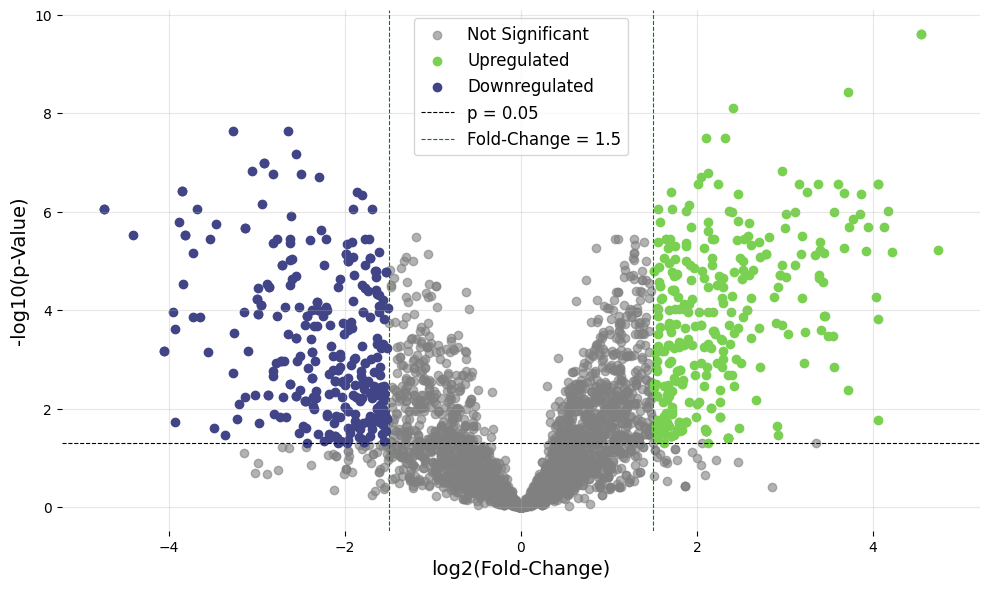

In [368]:
# Load the dataset to examine the structure
file_path = '/home/clony/Desktop/data_covid/initial_data/dataset_initial_24.csv'
data = pd.read_csv(file_path)


# Define column names (adjust if necessary)
log2fc_column = 'log2FC'
pvalue_column = 'pValue'

data = data.dropna(subset=["log2FC"]).copy()
data = data[~data["log2FC"].isin([float("inf"), float("-inf")])]

# Check if necessary columns exist
if log2fc_column in data.columns and pvalue_column in data.columns:
    # Remove NaN values
    data_cleaned = data.dropna(subset=[log2fc_column, pvalue_column])
    
    # Convert p-values to -log10(p-value) for plotting
    data_cleaned['-log10(pValue)'] = -np.log10(data_cleaned[pvalue_column])
    
    # Create a volcano plot
    plt.figure(figsize=(10, 6))

    # Highlight significant points
    significant_up = data_cleaned[(data_cleaned[log2fc_column] > 1.5) & (data_cleaned[pvalue_column] < 0.05)]
    significant_down = data_cleaned[(data_cleaned[log2fc_column] < -1.5) & (data_cleaned[pvalue_column] < 0.05)]
    non_significant = data_cleaned[~((data_cleaned[log2fc_column] > 1.5) & (data_cleaned[pvalue_column] < 0.05)) &
                                   ~((data_cleaned[log2fc_column] < -1.5) & (data_cleaned[pvalue_column] < 0.05))]
    
    # Use Viridis colormap
    cmap = plt.cm.viridis

    # Scatter plot for all sites
    plt.scatter(
        non_significant[log2fc_column],
        non_significant['-log10(pValue)'],
        c='gray',
        alpha=0.6,
        label='Not Significant'
    )
    
    # Upregulated points (Yellow from Viridis)
    plt.scatter(
        significant_up[log2fc_column],
        significant_up['-log10(pValue)'],
        c=cmap(0.8),  # Yellowish colors from Viridis
        label='Upregulated'
    )
    
    # Downregulated points (Bluish from Viridis)
    plt.scatter(
        significant_down[log2fc_column],
        significant_down['-log10(pValue)'],
        c=cmap(0.2),  # Bluish colors from Viridis
        label='Downregulated'
    )
    
    # Add plot labels and legend
    plt.xlabel('log2(Fold-Change)', fontsize=14)
    plt.ylabel('-log10(p-Value)', fontsize=14)
    plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=0.8, label='p = 0.05')
    plt.axvline(x=1.5, color='green', linestyle='--', linewidth=0.8, label='Fold-Change = 1.5')
    plt.axvline(x=-1.5, color='green', linestyle='--', linewidth=0.8)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    # Remove plot borders
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.savefig("volcano.svg", format="svg")
    plt.show()
    
    # Save the plot as an SVG file
    

else:
    print("Required columns ('log2FC', 'pValue') are missing. Please verify the dataset structure.")


In [371]:
significant_up

mean_log2FC = significant_up['log2FC'].mean()
std_dev_log2FC = significant_up['log2FC'].std()  # Standard deviation
variance_log2FC = significant_up['log2FC'].var()  # Variance
range_log2FC = significant_up['log2FC'].max() - significant_up['log2FC'].min()  # Range

# Print results
print(f"Mean of log2FC: {mean_log2FC}")
print(f"Standard Deviation of log2FC: {std_dev_log2FC}")
print(f"Variance of log2FC: {variance_log2FC}")
print(f"Range of log2FC: {range_log2FC}")

Mean of log2FC: 2.278963210702341
Standard Deviation of log2FC: 0.7132856638397559
Variance of log2FC: 0.5087764382393213
Range of log2FC: 3.2300000000000004


In [372]:
mean_log2FC = significant_down['log2FC'].mean()
std_dev_log2FC = significant_down['log2FC'].std()  # Standard deviation
variance_log2FC = significant_down['log2FC'].var()  # Variance
range_log2FC = significant_down['log2FC'].max() - significant_up['log2FC'].min()  # Range

# Print results
print(f"Mean of log2FC: {mean_log2FC}")
print(f"Standard Deviation of log2FC: {std_dev_log2FC}")
print(f"Variance of log2FC: {variance_log2FC}")
print(f"Range of log2FC: {range_log2FC}")

Mean of log2FC: -2.2667986798679864
Standard Deviation of log2FC: 0.647447854453671
Variance of log2FC: 0.41918872423666204
Range of log2FC: -3.02


In [356]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors
import matplotlib

# Load datasets
df_rokai_kinase_activity = pd.read_csv("./Desktop/data_covid/RoKAI/kinase_table.csv")
df_kinex_kinase_activity = pd.read_csv("/home/clony/Desktop/data_covid/Kinex/kinex_output.csv")
df_phosx_kinase_activity = pd.read_csv("/home/clony/Desktop/data_covid/phosX/kinase_activities_phosX.tsv", sep="\t")

# Normalize activity data and prepare for plotting
def prepare_data_for_plotting(df, activity_col, direction_col, bin_range=(0, 1), bin_step=0.1):
    max_value = df[activity_col].abs().max()
    df["Normalized Activity"] = df[activity_col].abs() / max_value
    bins = np.arange(bin_range[0], bin_range[1] + bin_step, bin_step)
    df["activity_bin"] = pd.cut(df["Normalized Activity"], bins=bins)
    df["Regulation"] = df[activity_col].apply(lambda x: "Upregulated" if x > 0 else "Downregulated")
    activity_counts = (
        df.groupby(["activity_bin", direction_col]).size().unstack(fill_value=0)
    )
    bin_labels = [f"{interval.left:.1f}-{interval.right:.1f}" for interval in activity_counts.index]
    return activity_counts, bin_labels

# Kinex activity scores
def calculate_kinex_activity_score(row):
    if row['dominant_direction'] == 'downregulated set':
        return -row['downregulated_enrichment_value']
    elif row['dominant_direction'] == 'upregulated set':
        return row['upregulated_enrichment_value']
    else:
        return None

df_kinex_kinase_activity["activity_score"] = df_kinex_kinase_activity.apply(calculate_kinex_activity_score, axis=1)

# Prepare data for Kinex, RoKAI, and PhosX
activity_counts_kinex, bin_labels_kinex = prepare_data_for_plotting(
    df_kinex_kinase_activity.copy(), activity_col="activity_score", direction_col="dominant_direction"
)
activity_counts_rokai, bin_labels_rokai = prepare_data_for_plotting(
    df_rokai_kinase_activity.copy(), activity_col="Activity", direction_col="Regulation"
)
activity_counts_phosx, bin_labels_phosx = prepare_data_for_plotting(
    df_phosx_kinase_activity.copy(), activity_col="Activity Score", direction_col="Regulation"
)

# Create subplots with shared x-axes and horizontal arrangement
fig = make_subplots(
    rows=1, cols=3, shared_yaxes=True, subplot_titles=("RoKAI", "PhosX", "Kinex"),
    horizontal_spacing=0.07  # Adjust spacing between horizontal subplots
)

# Viridis colormap for consistent color usage
cmap = matplotlib.colormaps.get_cmap("viridis")
upregulated_color = mcolors.rgb2hex(cmap(0.8))  # Yellowish color
downregulated_color = mcolors.rgb2hex(cmap(0.2))  # Bluish color

# Plot RoKAI
fig.add_trace(
    go.Bar(y=bin_labels_rokai, x=activity_counts_rokai.get("Upregulated", [0]),
           marker_color=upregulated_color, name="Upregulated", orientation='h', showlegend=False),
    row=1, col=1
)
fig.add_trace(
    go.Bar(y=bin_labels_rokai, x=activity_counts_rokai.get("Downregulated", [0]),
           marker_color=downregulated_color, name="Downregulated", orientation='h', showlegend=False),
    row=1, col=1
)

# Plot PhosX
fig.add_trace(
    go.Bar(y=bin_labels_phosx, x=activity_counts_phosx.get("Upregulated", [0]),
           marker_color=upregulated_color, name="Upregulated", orientation='h', showlegend=False),
    row=1, col=2
)
fig.add_trace(
    go.Bar(y=bin_labels_phosx, x=activity_counts_phosx.get("Downregulated", [0]),
           marker_color=downregulated_color, name="Downregulated", orientation='h', showlegend=False),
    row=1, col=2
)

# Plot Kinex
fig.add_trace(
    go.Bar(y=bin_labels_kinex, x=activity_counts_kinex.get("upregulated set", [0]),
           marker_color=upregulated_color, name="Upregulated", orientation='h', showlegend=True),
    row=1, col=3
)
fig.add_trace(
    go.Bar(y=bin_labels_kinex, x=activity_counts_kinex.get("downregulated set", [0]),
           marker_color=downregulated_color, name="Downregulated", orientation='h', showlegend=True),
    row=1, col=3
)

# Update layout with a single y-axis title and better subplot title spacing
fig.update_layout(
    height=600, width=1000,  # Adjust dimensions for horizontal layout
    margin=dict(t=40, b=40, l=40, r=10),
    yaxis_title="Normalized Activity Score",
    xaxis2_title="Number of Kinases",
    barmode="stack",
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
)

# Adjust subplot title spacing
for annotation in fig['layout']['annotations']:
    annotation['y'] += 0.03  # Move title up slightly
    annotation['font'] = dict(size=16)  # Increase title font size

# Save as PNG
fig.write_image("merged_kinase_activity_plot_horizontal.png", width=900, height=500, scale=2)
fig.show()


/tmp/ipykernel_387412/231852562.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_387412/231852562.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_387412/231852562.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

